## Loading the data

In [ ]:
#%matplotlib qt
from bincatsim import utils as ut
from bincatsim import processing as p
import grasp
stats = grasp.stats
from matplotlib.pyplot import *
import astropy.units as u

tns = {
    '200mas_360_ron': '20251008_155310',
    '500mas_90': '20251001_154655',
    '200mas_90': '20251001_115908',
    '200mas_45': '20250929_160852',
}

cal_psf = ut.load_psf(f"{ut.simpath}/observations/{tns['200mas_90']}/calibration.fits")
cube = ut.load_psf_cube(tns['200mas_90'])

## Image Parameter Determination

### Harmonic decomposition of the reduced Chi-squared:

$$ \ln{\chi^2_{red}(\varphi)} \simeq c_0 + c_2 \cos{2\varphi} + s_2 \sin{2\varphi} \quad ; \quad \text{k=2 term dominant for binaries} $$

 - `ipd_gof_harmonic_amplitude` : $ \sqrt{c_2^2 + s_2^2} $

 - `ipd_gof_harmonic_phase` : $ \mathcal{arctan2}\bigg(\dfrac{s_2}{c_2}\bigg) $

/mnt/nas/BINCAT/processing.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(0.25874226427061486, 64.99635182814706)

findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


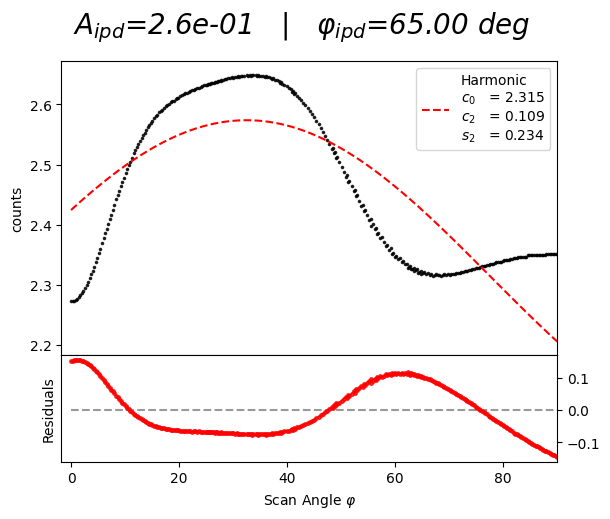

In [2]:
p.ipd_gof_harmonic(cube, cal_psf, show=True)

### Multi-Peak detection

Defined as the fraciton of succesful transit with multi-peaks detected on the psf

In [3]:
from ipywidgets import interact, widgets

def interactive_plot(index):
    clf()  # Clear the current figure
    # Call your modified plotting function (without show=True)
    maxima = p.find_local_maxima(cube[index], which='al', show=False)
    # If needed, add plt.title(f"Data {index}") or other customizations
    plot(cube[index].psf_x, label='PSF')
    scatter(*zip(*maxima), color='red', label='Maxima')
    legend()
    title(r'Local Maxima in PSF | $\varphi$='+f"{cube[index].phi:.2f}")
    xlabel('Pixel')
    ylabel('Intensity')
    grid()
    draw()  # Update the display

interact(interactive_plot, index=widgets.IntSlider(min=0, max=len(cube)-1, step=1, value=0, description='Data Index:'))

interactive(children=(IntSlider(value=0, description='Data Index:', max=308), Output()), _dom_classes=('widget…

<function __main__.interactive_plot(index)>

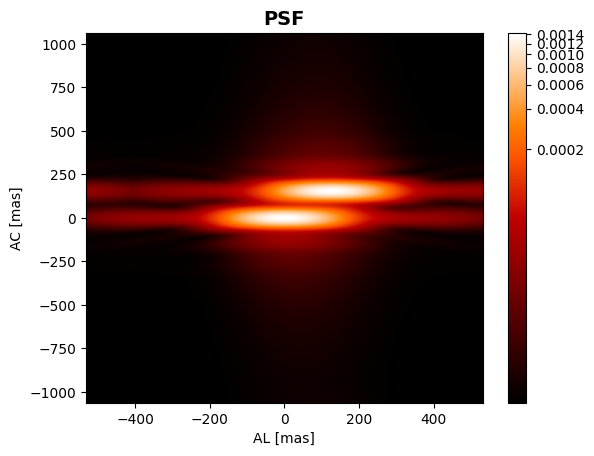

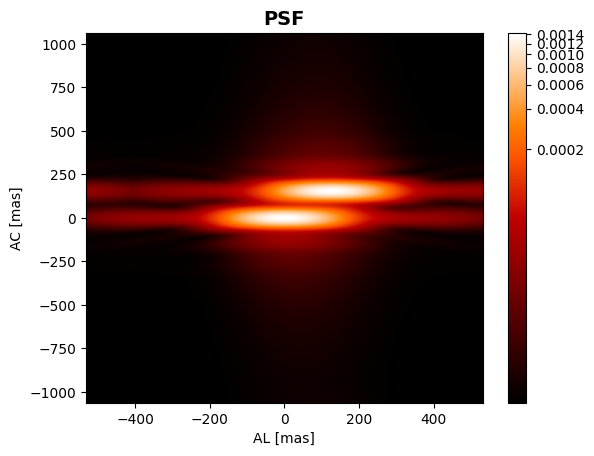

In [55]:
ut.display_psf(cube[171].psf_hr, mode='2d', save='psf_171_hr')

In [5]:
imp = p.ipd_frac_multipeak(cube, show=False)

In [6]:
maxima = []
phis = []
for img in cube:
    maxs = p.find_local_maxima(img)
    maxima.append(maxs)
    phis.append(img.phi)

maxima[0]

[(9, 0.13818851), (11, 0.13724136)]

Text(0.5, 1.0, 'Identified Maxima across Scan Angles')

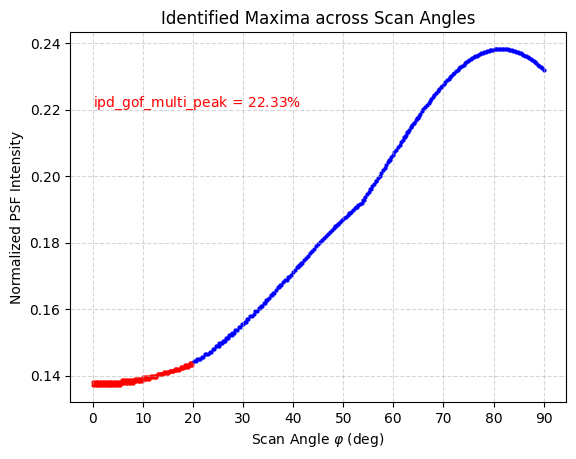

In [7]:
figure()
grid(alpha=0.5, linestyle='--')
for max,phi in zip(maxima, phis):
    scatter([phi]*len(max), [m[1] for m in max], color='red' if len(max) > 1 else 'blue', s=4)
text(0,0.221, r'$\mathrm{ipd\_gof\_multi\_peak}$'+f' = {imp*100:.2f}%', color='red')
xlabel(r'Scan Angle $\varphi$ (deg)')
ylabel('Normalized PSF Intensity')
yticks(np.arange(0.14, 0.25, 0.02))
xticks(np.arange(0, 91, 10))
title('Identified Maxima across Scan Angles')

In [62]:
ordered_cube = sorted(cube, key=lambda x: x.phi)

img_cube = [x.psf_2d for x in ordered_cube]
hr_cube = [x.psf_hr for x in ordered_cube]

MovieWriter ffmpeg unavailable; using Pillow instead.


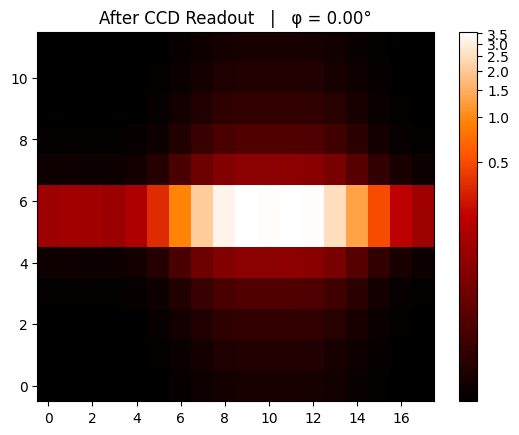

In [64]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from astropy.visualization import LogStretch, ImageNormalize, MinMaxInterval

norm = ImageNormalize(
    vmin=np.nanmin(img_cube[0]),
    vmax=np.nanmax(img_cube[0]),
    stretch=LogStretch(500),
    interval=MinMaxInterval(),
)


fig, ax = plt.subplots()
im = ax.imshow(img_cube[0], cmap='gist_heat', origin='lower', aspect='auto', norm=norm)
fig.colorbar(im, ax=ax)

def update(frame):
    norm = ImageNormalize(
        vmin=np.nanmin(img_cube[frame]),
        vmax=np.nanmax(img_cube[frame]),
        stretch=LogStretch(250),
        interval=MinMaxInterval(),
    )
    im.set_norm(norm)
    im.set_data(img_cube[frame])
    ax.set_title(f'After CCD Readout   |   φ = {ordered_cube[frame].phi:.2f}°')
    return (im,)

animation = FuncAnimation(fig, update, frames=len(img_cube), interval=200)
animation.save('psf_animation.gif', fps=15)

MovieWriter ffmpeg unavailable; using Pillow instead.


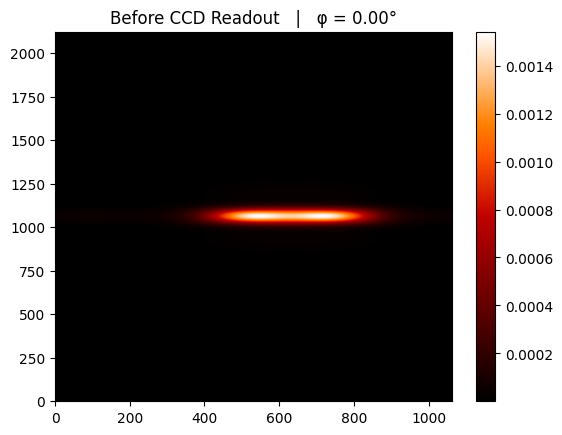

In [65]:
fig, ax = plt.subplots()
im = ax.imshow(hr_cube[0], cmap='gist_heat', origin='lower', aspect='auto')
fig.colorbar(im, ax=ax)

def update(frame):
    im.set_data(hr_cube[frame])
    ax.set_title(f'Before CCD Readout   |   φ = {ordered_cube[frame].phi:.2f}°')
    return (im,)


animation = FuncAnimation(fig, update, frames=len(hr_cube), interval=200)
animation.save('psfhr_animation.gif', fps=15)

MovieWriter ffmpeg unavailable; using Pillow instead.


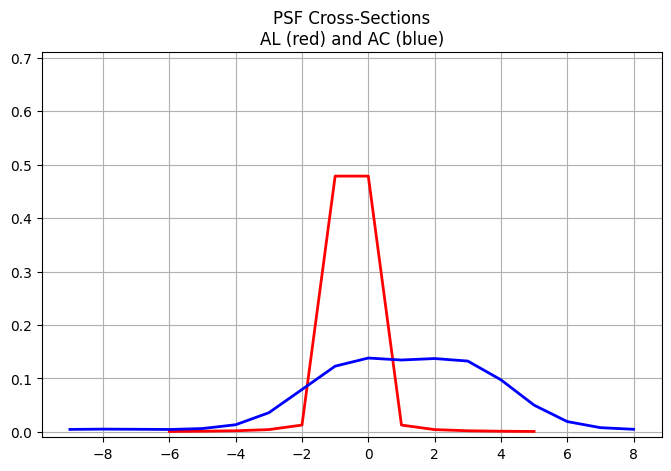

In [66]:
ycube = [x.psf_y for x in ordered_cube]
xcube = [x.psf_x for x in ordered_cube]

xy = np.arange(len(ycube[0])) - len(ycube[0]) // 2
xx = np.arange(len(xcube[0])) - len(xcube[0]) // 2

fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylim(-0.01,0.71)
ax.set_xticks(np.arange(-8,9,2))
ax.set_title(f'PSF Cross-Sections\nAL (red) and AC (blue)')
ax.grid()

pl = []
pl.extend(ax.plot(xy, ycube[0], c='red', linewidth=2))
pl.extend(ax.plot(xx, xcube[0], c='blue', linewidth=2))
    
def update(frame):
    pl[0].set_ydata(ycube[frame])
    pl[1].set_ydata(xcube[frame])
    return (pl[0], pl[1])

animation = FuncAnimation(fig, update, frames=len(ycube), interval=200)
animation.save('psf_cross_animation.gif', fps=15)